# Capital Allocation Line #

### Building Portfolios Maximizing Sharpe Ratio ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_daily_financial_data
from portfolios_toolkit import portfolio_variance
from portfolios_toolkit import eff_coefficients
from portfolios_toolkit import eff_equation

In [3]:
# Import data
tickers = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA']      # Tickers

# DataFrame to store everything
df_returns = pd.DataFrame()

for ticker in tickers:
    df = import_daily_financial_data(
        ticker=ticker, 
        start_date='2015-01-01', 
        end_date='2025-01-01', 
        returns=True
    )
    
    returns = df['returns'].rename(ticker)
    
    df_returns = pd.concat([df_returns, returns], axis=1)
    
    print(f'Data Ready for {ticker}')

[*********************100%***********************]  1 of 1 completed


Data Ready for AAPL


[*********************100%***********************]  1 of 1 completed


Data Ready for AMZN


[*********************100%***********************]  1 of 1 completed


Data Ready for META


[*********************100%***********************]  1 of 1 completed


Data Ready for MSFT


[*********************100%***********************]  1 of 1 completed

Data Ready for NVDA


In [4]:
df_returns

,AAPL,AMZN,META,MSFT,NVDA
2015-01-05,-0.028576,-0.020731,-0.016191,-0.009238,-0.017034
2015-01-06,0.000094,-0.023098,-0.013565,-0.014786,-0.030787
2015-01-07,0.013925,0.010544,0.000000,0.012625,-0.002609
2015-01-08,0.037702,0.006813,0.026309,0.028994,0.036927
2015-01-09,0.001072,-0.011818,-0.005644,-0.008441,0.004020
...,...,...,...,...,...
2024-12-24,0.011413,0.017573,0.013084,0.009330,0.003930
2024-12-26,0.003171,-0.008770,-0.007266,-0.002781,-0.002070
2024-12-27,-0.013331,-0.014641,-0.005884,-0.017453,-0.021088
2024-12-30,-0.013352,-0.011010,-0.014391,-0.013328,0.003497


In [5]:
# Create the expected returns and standard deviations
expected_returns = df_returns.mean()
volatility = df_returns.dropna().std()
cov_matrix = df_returns.dropna().cov()

In [6]:
# Get the coefficients of the Efficient Frontier
coefficients = eff_coefficients(expected_returns, cov_matrix)

coefficients

(0.0004389492599806269, 0.4863698959781316, 304.1279775569915)

In [7]:
# Create a rango of values for mu_P
mu_P_values = np.linspace(0.0, 0.004, 400)

# Evaluate the equation for mu_P values
sigma_P_values = eff_equation(coefficients, mu_P_values).reshape(-1, 1)

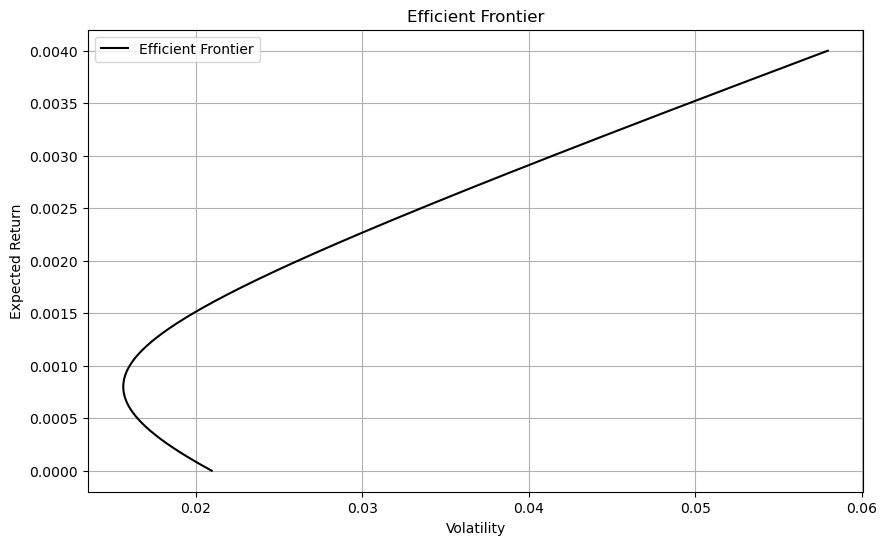

In [8]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [9]:
# The Most Efficient Portfolio is that which maximizes the Sharp Ratio
rfr = 0.0001

Let us find the Tangency Portfolio

Tangency Returns: $ \mu_T = \frac{2\pi_0 - \pi_1r_f}{\pi_1 - 2\pi_2r_f} $

In [10]:
# Obtain the values
pi_0 = coefficients[0]
pi_1 = coefficients[1]
pi_2 = coefficients[2]

tangency_returns = ((2*pi_0 - pi_1*rfr)/(pi_1 - 2*pi_2*rfr))
tangency_volat = eff_equation(coefficients, tangency_returns)

print(f"The Tangency Portfolio Returns are: {tangency_returns}")
print(f"The Tangency Portfolio Volatility is: {tangency_volat}")

The Tangency Portfolio Returns are: 0.0019487078770739354
The Tangency Portfolio Volatility is: 0.025417926136637382


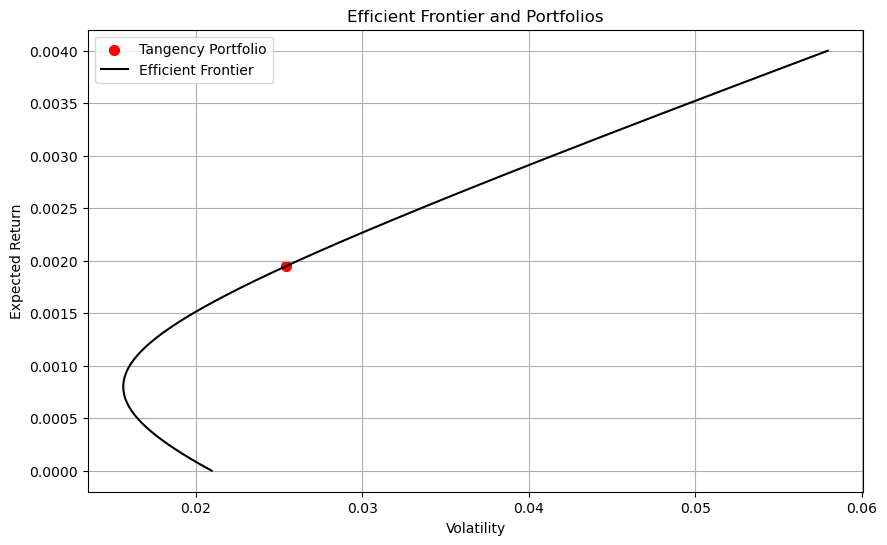

In [11]:
# Create the Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [12]:
# The Maximum Sharpe Ratio is the slope of the capital allocation line
sharpe_ratio = (tangency_returns - rfr)/tangency_volat

print(f"The Maximum Sharpe Ratio is: {sharpe_ratio}")

The Maximum Sharpe Ratio is: 0.07273244351785291


In [13]:
# Define the CAL
def CAL(
    rfr, 
    sigma_P
):
    return rfr + sharpe_ratio*sigma_P

In [14]:
# Create Range for Sigma
sigma_cal_values = np.linspace(0.0, 0.05, 400)

# Evaluate for each value of sigma
mu_cal_values = CAL(rfr, sigma_cal_values).reshape(-1, 1)

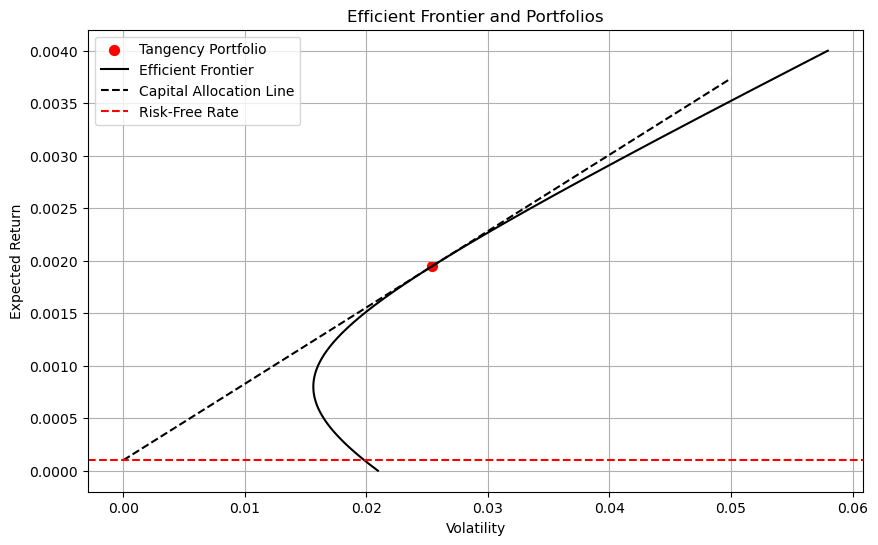

In [15]:
# Create Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')
plt.plot(sigma_cal_values, mu_cal_values, label=r'Capital Allocation Line', color='black', linestyle='--')
plt.axhline(y=rfr, color='r', linestyle='--', label='Risk-Free Rate')

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [16]:
# Get the Weights of the Tangency Portfolio
def weights(desired_returns):
    # Number of assets
    n = len(expected_returns)
    
    # Create inputs
    mu = expected_returns.values.flatten().reshape(-1, 1)  # Expected Returns
    Sigma = cov_matrix.values  # Covariance Matrix
    Sigma_inv = np.linalg.inv(Sigma)  # Inverse Covariance Matrix
    iota = np.ones((n, 1))  # Vector of Ones

    # Create components
    A = np.dot(np.dot(mu.T, Sigma_inv), mu)
    B = np.dot(np.dot(iota.T, Sigma_inv), mu)
    C = np.dot(np.dot(iota.T, Sigma_inv), iota)
    D = (A * C) - (B * B)

    # Calculate the weights
    first_part = (((desired_returns * C) - B) / D) * (Sigma_inv @ mu)
    second_part = ((A - (desired_returns * B)) / D) * (Sigma_inv @ iota)

    return first_part + second_part 

In [17]:
# Calculate the weights
tangency_weights = weights(tangency_returns)

tangency_weights

array([[ 0.18115175],
       [ 0.28725223],
       [-0.25939401],
       [ 0.06491616],
       [ 0.72607386]])

In [18]:
# Now let us assume we there are an investor willing to take lower risk to reach worse returns
cal_returns = 0.003

#In a normal case
normal_case_weights = weights(cal_returns)

print(normal_case_weights)
print(f'The sum of weights is: {normal_case_weights.sum().round(2)}')

[[-0.01623533]
 [ 0.40454808]
 [-0.54242933]
 [-0.33772315]
 [ 1.49183972]]
The sum of weights is: 1.0


In [31]:
# Define the function to get the weights for the CAL
def capital_allocation_line_weights(
        desired_returns,
        tangency_returns = tangency_returns,
        risk_free_rate = rfr,
):
    # Calculate Tangents Weights
    tan_ws = weights(tangency_returns)
    
    # Calculate discount factor
    disfact = (desired_returns - risk_free_rate) / (tangency_returns - risk_free_rate)
    
    # Calculate weights
    cal_ws = tan_ws * disfact

    return cal_ws

In [32]:
# Calculate the weights
cal_ws = capital_allocation_line_weights(cal_returns)

print(cal_ws)
print(f'The sum of weights is: {cal_ws.sum().round(4)}')

if cal_ws.sum() < 1:
    print('You are a lender')
elif cal_ws.sum() > 1:
    print('You are a borrower')
else:
    print('You are special')

[[ 0.28416608]
 [ 0.450602  ]
 [-0.40690183]
 [ 0.10183159]
 [ 1.13896534]]
The sum of weights is: 1.5687
You are a borrower


In [33]:
# Get the volatility given the desired returns
def capital_allocation_line_volatility(desired_returns):
    # Calculate the volatility
    sigma = (desired_returns - rfr) / sharpe_ratio
    
    return sigma

In [34]:
# Calculate Volatility
cal_volat = capital_allocation_line_volatility(cal_returns)

print(f'The CAL Portfolio Risk: {cal_volat}')

The CAL Portfolio Risk: 0.039872165154030144


In [35]:
# You can get the same result by using the standard equation
cal_var = portfolio_variance(cal_ws, df_returns)
cal_volat_alt = np.sqrt(cal_var)

print(f'CAL Portfolio Variance: {cal_volat_alt[0][0]}')

CAL Portfolio Variance: 0.039872165154030144


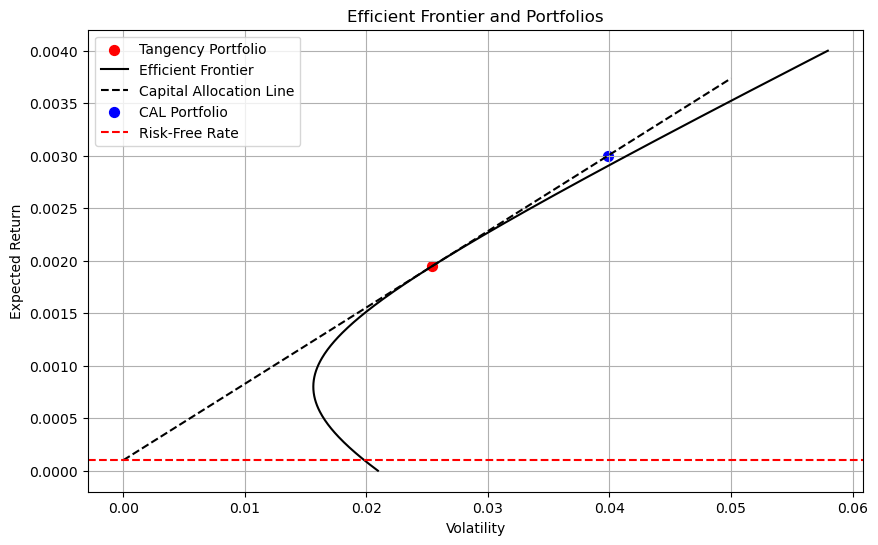

In [36]:
# Create Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')
plt.plot(sigma_cal_values, mu_cal_values, label=r'Capital Allocation Line', color='black', linestyle='--')
plt.scatter(cal_volat, cal_returns, color='blue', s=50, label='CAL Portfolio')
plt.axhline(y=rfr, color='r', linestyle='--', label='Risk-Free Rate')


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [59]:
# Create Portfolios
tangency_portfolio = df_returns @ tangency_weights

# Create DataFrame
df_returns_ports = df_returns.copy()

df_returns_ports['Tangency Portfolio'] = tangency_portfolio

df_returns_ports

,AAPL,AMZN,META,MSFT,NVDA,Tangency Portfolio
2015-01-05,-0.028576,-0.020731,-0.016191,-0.009238,-0.017035,-0.019900
2015-01-06,0.000094,-0.023098,-0.013565,-0.014786,-0.030787,-0.026413
2015-01-07,0.013925,0.010544,0.000000,0.012625,-0.002609,0.004477
2015-01-08,0.037703,0.006813,0.026309,0.028994,0.036927,0.030657
2015-01-09,0.001072,-0.011818,-0.005644,-0.008441,0.004020,0.000634
...,...,...,...,...,...,...
2024-12-24,0.011413,0.017573,0.013084,0.009330,0.003930,0.007181
2024-12-26,0.003171,-0.008770,-0.007266,-0.002781,-0.002070,-0.001744
2024-12-27,-0.013331,-0.014641,-0.005884,-0.017453,-0.021088,-0.021539
2024-12-30,-0.013352,-0.011010,-0.014391,-0.013328,0.003497,-0.000174


### Comparing Different Portfolios ###

In [60]:
# Define the desired portfolios
returns_list = [0.001, 0.0015, 0.0025, 0.003]

# Loop over desired returns with index
for r, ret in enumerate(returns_list):
    
    # Calculate Weights
    ws = capital_allocation_line_weights(ret)
    
    # Calculate the Portfolio Returns
    portfolio = df_returns.values @ ws
    
    # Save it in the DataFrame
    df_returns_ports[f'port_{r}'] = portfolio
    

In [61]:
df_returns_ports

,AAPL,AMZN,META,MSFT,NVDA,Tangency Portfolio,port_0,port_1,port_2,port_3
2015-01-05,-0.028576,-0.020731,-0.016191,-0.009238,-0.017035,-0.019900,-0.009688,-0.015070,-0.025834,-0.031216
2015-01-06,0.000094,-0.023098,-0.013565,-0.014786,-0.030787,-0.026413,-0.012859,-0.020002,-0.034289,-0.041433
2015-01-07,0.013925,0.010544,0.000000,0.012625,-0.002609,0.004477,0.002179,0.003390,0.005812,0.007023
2015-01-08,0.037703,0.006813,0.026309,0.028994,0.036927,0.030657,0.014924,0.023216,0.039798,0.048090
2015-01-09,0.001072,-0.011818,-0.005644,-0.008441,0.004020,0.000634,0.000309,0.000480,0.000823,0.000995
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011413,0.017573,0.013084,0.009330,0.003930,0.007181,0.003496,0.005438,0.009322,0.011264
2024-12-26,0.003171,-0.008770,-0.007266,-0.002781,-0.002070,-0.001744,-0.000849,-0.001321,-0.002264,-0.002735
2024-12-27,-0.013331,-0.014641,-0.005884,-0.017453,-0.021088,-0.021539,-0.010486,-0.016311,-0.027962,-0.033787
2024-12-30,-0.013352,-0.011010,-0.014391,-0.013328,0.003497,-0.000174,-0.000085,-0.000132,-0.000226,-0.000274


In [62]:
def calculate_analytics(df_returns, risk_free_rate=0.0):
    # Trading Days in one Year
    ann_factor = 252  
    
    # Annualized Returns
    annualized_return = df_returns.mean() * ann_factor
    
    # Annualized Volatility
    annualized_std = df_returns.std() * np.sqrt(ann_factor)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    
    # Max Drawdown
    cumulative_returns = (1 + df_returns.div(100)).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max) - 1
    max_drawdown = drawdown.min()

    # VaR at 95%
    var_95 = df_returns.quantile(0.05)

    # Create DF
    summary_df = pd.DataFrame({
        "Annualized Returns": annualized_return,
        "Annualized Volatility": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": var_95
    })
    
    return summary_df

In [63]:
# Now the table
analytics_table = calculate_analytics(df_returns_ports)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,0.233536,0.284654,0.820421,-0.004855,-0.027362
AMZN,0.266007,0.326594,0.814489,-0.008223,-0.031091
META,0.201784,0.378558,0.533033,-0.014499,-0.033784
MSFT,0.235581,0.271307,0.868319,-0.004639,-0.026941
NVDA,0.563863,0.482208,1.169335,-0.010846,-0.045559
Tangency Portfolio,0.491075,0.403497,1.217046,-0.007318,-0.038478
port_0,0.239068,0.196433,1.217046,-0.003566,-0.018732
port_1,0.371884,0.305563,1.217046,-0.005544,-0.029139
port_2,0.637515,0.523821,1.217046,-0.009495,-0.049952
port_3,0.770330,0.632951,1.217046,-0.011467,-0.060359
